 Détection de Pneumonie avec Transfer Learning  et MLflow
 Projet : Classification binaire d'images de radios thoraciques
 Auteur : [Bafodé Jaiteh]
 Date : 25/05/2025

##  Pneumonia_Detection : 


###  **OBJECTIF DU PROJET:  :**

 Utiliser un modèle DenseNet121 pré-entraîné pour détecter la pneumonie 
sur des radios thoraciques..  
 Application du transfer learning pour améliorer la précision du modèle.
 Prétraitement des données avec augmentation pour améliorer la robustesse du modèle. 
 Modelisation et évaluation des performances du modèle sur un jeu de données de test.

---
---






## Configuration gpu

In [1]:
import tensorflow as tf
import os

# Configuration GPU stricte
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Configuration mémoire GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # Limite la mémoire GPU à 2GB
            tf.config.experimental.set_virtual_device_configuration(
                gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]
            )
        print(f" GPU configuré: {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f" Erreur GPU: {e}")

# Force l'utilisation CPU si GPU pose problème
# tf.config.set_visible_devices([], 'GPU')  # Décommentez si nécessaire

print("🔧 Configuration GPU terminée")

🔧 Configuration GPU terminée


In [2]:

# Configuration TensorFlow AVANT d'utiliser tf
print("🔧 Configuration de TensorFlow...")

# Configuration de la mémoire GPU (si disponible)
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"🚀 GPU détecté et configuré: {len(gpus)} GPU(s)")
    else:
        print("💻 Utilisation du CPU (aucun GPU détecté)")
except:
    print("💻 Configuration GPU non disponible, utilisation du CPU")

# Limitation de l'utilisation mémoire pour stabilité
try:
    tf.config.threading.set_intra_op_parallelism_threads(2)
    tf.config.threading.set_inter_op_parallelism_threads(2)
    print("  Threads limités pour optimiser la stabilité")
except:
    print("  Configuration des threads non disponible")

🔧 Configuration de TensorFlow...
💻 Utilisation du CPU (aucun GPU détecté)
⚙️  Threads limités pour optimiser la stabilité


###  Import des bibliothèques et packages nécéssaire :

```

In [3]:
# Imports nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import joblib
import os
from pathlib import Path
from tqdm import tqdm

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Flatten, BatchNormalization  
from tensorflow.keras.applications import DenseNet121, ResNet50, EfficientNetB0
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import (
    EarlyStopping, 
    ReduceLROnPlateau, 
    ModelCheckpoint,
    TensorBoard
)

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    classification_report
)

# MLflow 
import mlflow
import mlflow.tensorflow
# Configuration
DATA_PATH = Path("data/chest_xray")
print(f" Imports chargés")
print(f" DATA_PATH: {DATA_PATH} (existe: {DATA_PATH.exists()})")
print(" Tous les imports réussis")

 Imports chargés
 DATA_PATH: data\chest_xray (existe: True)
 Tous les imports réussis


## Paramètres globaux

In [4]:

IMG_SIZE = (224, 224)  # Taille d'entrée pour DenseNet121
BATCH_SIZE = 32        # Batch size réduit pour DenseNet (plus lourd)
EPOCHS = 75
LEARNING_RATE = 0.00005

In [5]:
# Chemins des données
# Le dataset est dans le dossier data/chest_xray
DATA_PATH = "data/chest_xray"
TRAIN_PATH = os.path.join(DATA_PATH, "train")
VAL_PATH = os.path.join(DATA_PATH, "val") 
TEST_PATH = os.path.join(DATA_PATH, "test")

## Chemins des données

In [6]:
# Structure attendue : chest_xray/train/NORMAL et chest_xray/train/PNEUMONIA
DATA_PATH = "chest_xray"
TRAIN_PATH = os.path.join(DATA_PATH, "train")
VAL_PATH = os.path.join(DATA_PATH, "val") 
TEST_PATH = os.path.join(DATA_PATH, "test")

## Exploration et préparation des données 

In [7]:

  

def explore_dataset(data_path):
    """
    Explore la structure du dataset et affiche des statistiques
    """
    print(f"\n🔍 EXPLORATION DU DATASET")
    print("=" * 50)
    
    if not os.path.exists(data_path):
        print(f"  Le dossier {data_path} n'existe pas.")
        print(" Vérifiez que le dataset est bien dans le dossier 'data/chest_xray'")
        print(" Structure attendue: data/chest_xray/train/, data/chest_xray/val/, data/chest_xray/test/")
        print(" Exploration impossible.")
        return False
    
    total_images = 0
    dataset_info = {}
    
    for subset in ['train', 'val', 'test']:
        subset_path = os.path.join(data_path, subset)
        if os.path.exists(subset_path):
            print(f"\n Dossier {subset.upper()}:")
            subset_total = 0
            dataset_info[subset] = {}
            
            for class_name in ['NORMAL', 'PNEUMONIA']:
                class_path = os.path.join(subset_path, class_name)
                if os.path.exists(class_path):
                    count = len([f for f in os.listdir(class_path) 
                               if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                    print(f"  - {class_name}: {count} images")
                    dataset_info[subset][class_name] = count
                    subset_total += count
                else:
                    print(f"  - {class_name}: Dossier manquant ❌")
                    dataset_info[subset][class_name] = 0
            
            print(f"  Total {subset}: {subset_total} images")
            total_images += subset_total
        else:
            print(f"\n Dossier {subset.upper()}: Manquant ❌")
    
    if total_images > 0:
        print(f"\n RÉSUMÉ DU DATASET:")
        print(f"   Total: {total_images} images")
        
        # Calcul des pourcentages
        total_normal = sum([dataset_info[s].get('NORMAL', 0) for s in dataset_info])
        total_pneumonia = sum([dataset_info[s].get('PNEUMONIA', 0) for s in dataset_info])
        
        if total_images > 0:
            normal_pct = (total_normal / total_images) * 100
            pneumonia_pct = (total_pneumonia / total_images) * 100
            print(f"   NORMAL: {total_normal} ({normal_pct:.1f}%)")
            print(f"   PNEUMONIA: {total_pneumonia} ({pneumonia_pct:.1f}%)")
            
            if abs(normal_pct - pneumonia_pct) > 20:
                print(f"    Dataset déséquilibré détecté!")
    
    return total_images > 0

def create_demo_dataset():
    """
    Crée un dataset de démonstration avec des images synthétiques
    pour tester le code sans télécharger le vrai dataset
    """
    print(f"\n🧪 CRÉATION D'UN DATASET DE DÉMONSTRATION")
    print("=" * 50)
    
    demo_path = "demo_chest_xray"
    
    if os.path.exists(demo_path):
        print(f" Dataset de démo existe déjà: {demo_path}")
        return demo_path
    
    try:
        # Création de la structure
        for subset in ['train', 'val', 'test']:
            for class_name in ['NORMAL', 'PNEUMONIA']:
                os.makedirs(os.path.join(demo_path, subset, class_name), exist_ok=True)
        
        # Génération d'images synthétiques
        print(" Génération d'images synthétiques...")
        
        import numpy as np
        from PIL import Image
        
        # Nombre d'images par catégorie
        counts = {
            'train': {'NORMAL': 20, 'PNEUMONIA': 30},
            'val': {'NORMAL': 5, 'PNEUMONIA': 8},
            'test': {'NORMAL': 10, 'PNEUMONIA': 15}
        }
        
        for subset, class_counts in counts.items():
            for class_name, count in class_counts.items():
                for i in range(count):
                    # Génération d'image synthétique
                    if class_name == 'NORMAL':
                        # Images plus claires pour "normal"
                        img_array = np.random.randint(100, 200, (224, 224), dtype=np.uint8)
                    else:
                        # Images avec plus de variation pour "pneumonia"
                        img_array = np.random.randint(50, 150, (224, 224), dtype=np.uint8)
                        # Ajout de quelques "taches" pour simuler
                        for _ in range(5):
                            x, y = np.random.randint(0, 200, 2)
                            img_array[x:x+24, y:y+24] = np.random.randint(20, 80)
                    
                    # Sauvegarde
                    img = Image.fromarray(img_array, mode='L')
                    filename = f"{class_name.lower()}_{i+1:03d}.jpg"
                    filepath = os.path.join(demo_path, subset, class_name, filename)
                    img.save(filepath)
        
        print(f" Dataset de démo créé: {demo_path}")
        print("⚠  Note: Ce sont des images synthétiques pour tester le code uniquement!")
        return demo_path
        
    except Exceptionas e:
        print(f" Erreur lors de la création du dataset de démo: {e}")
        return None

# Exploration du dataset principal
print(" RECHERCHE DU DATASET PRINCIPAL...")
dataset_exists = explore_dataset(DATA_PATH)

# Si pas de dataset principal, proposer le dataset de démo
if not dataset_exists:
    print(f"\n SOLUTION TEMPORAIRE: DATASET DE DÉMONSTRATION")
    print("=" * 60)
    print("En attendant de télécharger le vrai dataset, voulez-vous:")
    print("1.  Créer un dataset de démonstration pour tester le code")
    print("2.   Passer cette étape et continuer sans données")
    print()
    
    # Création automatique du dataset de démo pour la démonstration
    demo_path = create_demo_dataset()
    if demo_path:
        print(f"\n Utilisation du dataset de démo pour la suite...")
        DATA_PATH = demo_path
        TRAIN_PATH = os.path.join(DATA_PATH, "train")
        VAL_PATH = os.path.join(DATA_PATH, "val")
        TEST_PATH = os.path.join(DATA_PATH, "test")
        dataset_exists = True
        print(f" Chemins mis à jour vers le dataset de démo")
    else:
        print(f" Impossible de créer le dataset de démo")
        
print(f"\n CHEMINS FINAUX:")
print(f"  - Dataset: {DATA_PATH}")
print(f"  - Entraînement: {TRAIN_PATH}")
print(f"  - Validation: {VAL_PATH}")
print(f"  - Test: {TEST_PATH}")
print(f"  - Dataset disponible: {' Oui' if dataset_exists else ' Non'}")

 RECHERCHE DU DATASET PRINCIPAL...

 EXPLORATION DU DATASET
  Le dossier chest_xray n'existe pas.
 Vérifiez que le dataset est bien dans le dossier 'data/chest_xray'
 Structure attendue: data/chest_xray/train/, data/chest_xray/val/, data/chest_xray/test/
 Exploration impossible.

 SOLUTION TEMPORAIRE: DATASET DE DÉMONSTRATION
En attendant de télécharger le vrai dataset, voulez-vous:
1.  Créer un dataset de démonstration pour tester le code
2.   Passer cette étape et continuer sans données


 CRÉATION D'UN DATASET DE DÉMONSTRATION
 Dataset de démo existe déjà: demo_chest_xray

 Utilisation du dataset de démo pour la suite...
 Chemins mis à jour vers le dataset de démo

 CHEMINS FINAUX:
  - Dataset: demo_chest_xray
  - Entraînement: demo_chest_xray\train
  - Validation: demo_chest_xray\val
  - Test: demo_chest_xray\test
  - Dataset disponible:  Oui


In [8]:

import tensorflow as tf
print(' TensorFlow CPU version:', tf.__version__)
print(' Python version:', __import__('sys').version.split()[0])

# Test simple
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=(10,))])
x = tf.random.normal((32, 10))
y = model(x)
print(' Test réussi - Shape:', y.shape)
print(' TensorFlow fonctionne parfaitement!')


 TensorFlow CPU version: 2.13.0
 Python version: 3.10.11
 Test réussi - Shape: (32, 1)
 TensorFlow fonctionne parfaitement!


# CRÉATION DES GÉNÉRATEURS DE DONNÉES AVEC IMAGEDATAGENERATOR

In [9]:
def create_data_generators():
    """
    Crée les générateurs de données avec ImageDataGenerator
    """
    print("\n CRÉATION DES GÉNÉRATEURS DE DONNÉES")
    print("=" * 50)
    
    # Générateur pour l'entraînement avec augmentation de données
    train_datagen = ImageDataGenerator(
        rescale=1./255,                    # Normalisation [0,1]
        rotation_range=15,                 # Rotation ±15°
        width_shift_range=0.1,             # Décalage horizontal 10%
        height_shift_range=0.1,            # Décalage vertical 10%
        shear_range=0.1,                   # Cisaillement
        zoom_range=0.1,                    # Zoom ±10%
        horizontal_flip=True,              # Retournement horizontal
        vertical_flip=False,               # Pas de retournement vertical pour les radios
        fill_mode='nearest',               # Remplissage pixels
        brightness_range=[0.8, 1.2]       # Variation luminosité
    )
    
    # Générateur pour validation et test (sans augmentation)
    val_test_datagen = ImageDataGenerator(
        rescale=1./255  # Seulement normalisation
    )
    
    print("📋 Paramètres d'augmentation configurés:")
    print("  - Rotation: ±15°")
    print("  - Décalages: ±10%")
    print("  - Zoom: ±10%")
    print("  - Retournement horizontal: Oui")
    print("  - Variation luminosité: 0.8-1.2")
    
    try:
        # Générateur d'entraînement
        train_generator = train_datagen.flow_from_directory(
            TRAIN_PATH,
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='binary',  # Classification binaire
            shuffle=True,
            seed=42
        )
        
        # Générateur de validation
        val_generator = val_test_datagen.flow_from_directory(
            VAL_PATH,
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='binary',
            shuffle=False
        )
        
        # Générateur de test
        test_generator = val_test_datagen.flow_from_directory(
            TEST_PATH,
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='binary',
            shuffle=False
        )
        
        print("\n Générateurs créés avec succès!")
        print(f" Classes détectées: {train_generator.class_indices}")
        print(f" Nombre de batches d'entraînement: {len(train_generator)}")
        print(f" Nombre de batches de validation: {len(val_generator)}")
        print(f" Nombre de batches de test: {len(test_generator)}")
        
        return train_generator, val_generator, test_generator
        
    except Exception as e:
        print(f" Erreur lors de la création des générateurs: {e}")
        print(" Vérifiez la structure des dossiers et la présence des images")
        return None, None, None

# Création des générateurs
if dataset_exists:
    train_gen, val_gen, test_gen = create_data_generators()
else:
    train_gen, val_gen, test_gen = None, None, None


 CRÉATION DES GÉNÉRATEURS DE DONNÉES
📋 Paramètres d'augmentation configurés:
  - Rotation: ±15°
  - Décalages: ±10%
  - Zoom: ±10%
  - Retournement horizontal: Oui
  - Variation luminosité: 0.8-1.2
Found 50 images belonging to 2 classes.
Found 13 images belonging to 2 classes.
Found 25 images belonging to 2 classes.

 Générateurs créés avec succès!
 Classes détectées: {'NORMAL': 0, 'PNEUMONIA': 1}
 Nombre de batches d'entraînement: 2
 Nombre de batches de validation: 1
 Nombre de batches de test: 1


## Visualisation d'échantillon d'images 


  VISUALISATION D'ÉCHANTILLONS
 Récupération d'un batch d'images...
 Batch récupéré - Shape: (32, 224, 224, 3), Labels: (32,)
 Range des pixels: [0.004, 0.992]


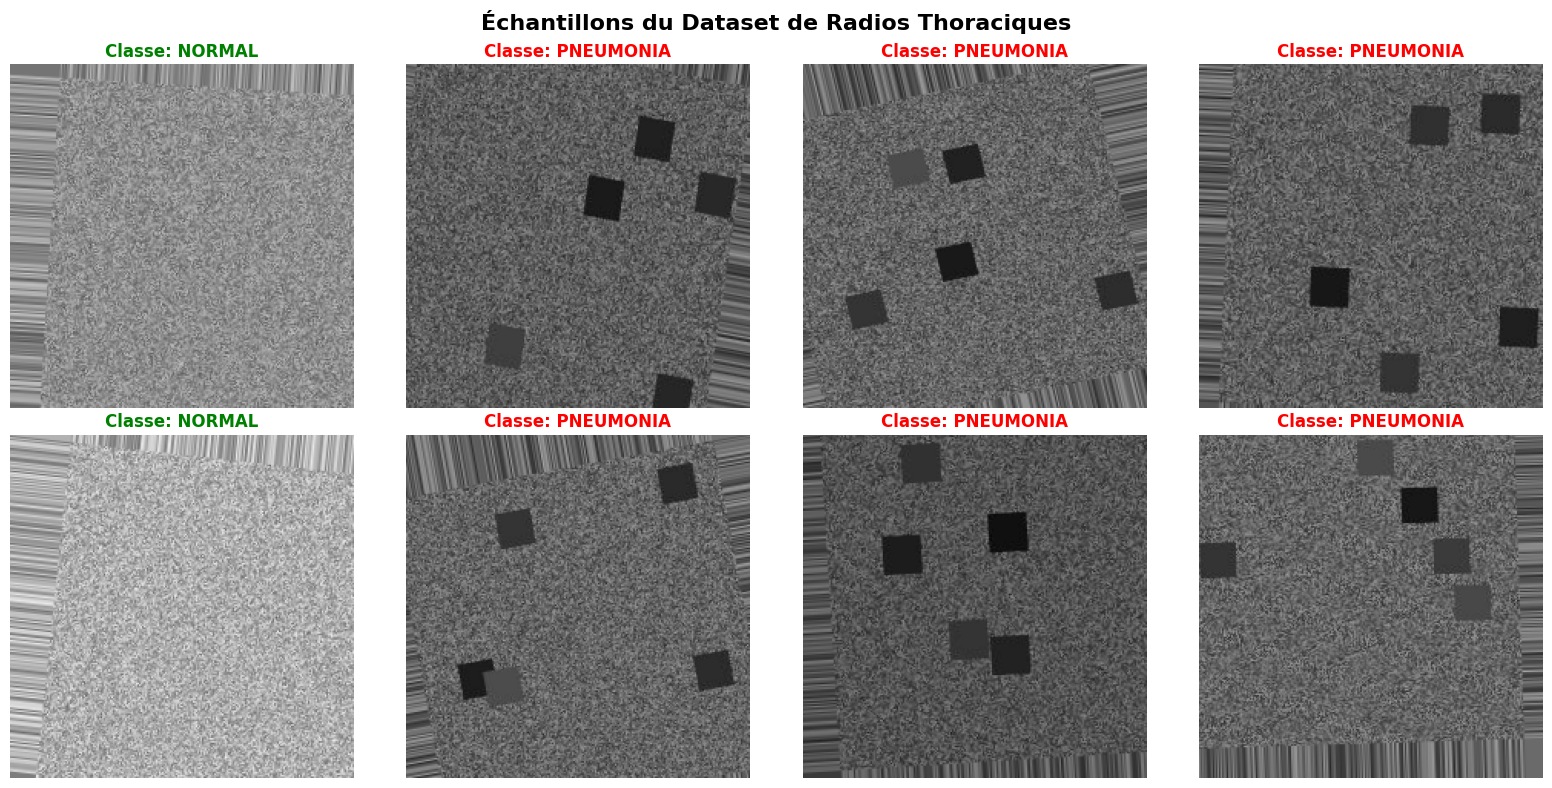

 Visualisation terminée!


In [10]:
def visualize_samples(generator, num_samples=8):
    """
    Affiche quelques échantillons du dataset avec leurs labels
    """
    if generator is None:
        print("⚠  Générateur non disponible pour la visualisation")
        return
        
    print(f"\n  VISUALISATION D'ÉCHANTILLONS")
    print("=" * 50)
    
    try:
        # Reset du générateur pour éviter les problèmes
        generator.reset()
        
        # Récupération d'un batch
        print(" Récupération d'un batch d'images...")
        batch_images, batch_labels = next(generator)
        
        print(f" Batch récupéré - Shape: {batch_images.shape}, Labels: {batch_labels.shape}")
        print(f" Range des pixels: [{batch_images.min():.3f}, {batch_images.max():.3f}]")
        
        # Configuration de matplotlib
        plt.style.use('default')  # Reset du style
        
        # Configuration de la figure
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        fig.suptitle("Échantillons du Dataset de Radios Thoraciques", fontsize=16, fontweight='bold')
        
        # Aplatir les axes pour faciliter l'itération
        axes = axes.flatten()
        
        for i in range(min(num_samples, len(batch_images))):
            # Affichage de l'image
            img = batch_images[i]
            
            # Vérification si l'image est en couleur ou niveaux de gris
            if len(img.shape) == 3 and img.shape[-1] == 3:
                # Image couleur
                axes[i].imshow(img)
            else:
                # Image en niveaux de gris
                if len(img.shape) == 3:
                    img = img[:,:,0]  # Prendre le premier canal
                axes[i].imshow(img, cmap='gray')
            
            # Détermination de la classe et couleur
            label = "PNEUMONIA" if batch_labels[i] == 1 else "NORMAL"
            color = "red" if batch_labels[i] == 1 else "green"
            
            # Ajout du titre avec la classe
            axes[i].set_title(f"Classe: {label}", color=color, fontsize=12, fontweight='bold')
            axes[i].axis('off')
        
        # Masquer les sous-graphiques non utilisés
        for i in range(num_samples, len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        
        # Force l'affichage
        plt.show()
        
        print(" Visualisation terminée!")
        
    except Exception as e:
        print(f" Erreur lors de la visualisation: {e}")
        print(" Causes possibles:")
        print("  - Dataset non trouvé ou mal structuré")
        print("  - Problème avec les générateurs de données")
        print("  - Problème d'affichage matplotlib")

# Visualisation des échantillons
if train_gen is not None:
    visualize_samples(train_gen)

** Création du modèle avec Transfer Learning **

In [11]:
def create_densenet_model():
    """
    Crée un modèle utilisant DenseNet121 pré-entraîné avec transfer learning
    """
    print(f"\n CRÉATION DU MODÈLE AVEC DENSENET121")
    print("=" * 50)
    
    try:
        # Nettoyage de la mémoire
        tf.keras.backend.clear_session()
        
        # Chargement du modèle DenseNet121 pré-entraîné
        print(" Chargement de DenseNet121 pré-entraîné...")
        base_model = DenseNet121(
            weights='imagenet',        # Poids pré-entraînés sur ImageNet
            include_top=False,         # Exclusion de la couche de classification
            input_shape=(*IMG_SIZE, 3), # Forme d'entrée (224, 224, 3)
            pooling=None               # Pas de pooling automatique
        )
        
        # Gel des couches pré-entraînées pour le transfer learning
        base_model.trainable = False
        
        print(f" Modèle de base DenseNet121:")
        print(f"  - Nombre de couches: {len(base_model.layers)}")
        print(f"  - Paramètres totaux: {base_model.count_params():,}")
        print(f"  - Paramètres entraînables: {sum([tf.keras.backend.count_params(w) for w in base_model.trainable_weights]):,}")
        
        # Construction du modèle complet
        inputs = base_model.input
        x = base_model.output
        
        # Ajout de couches personnalisées pour la classification binaire
        x = GlobalAveragePooling2D(name='global_avg_pooling')(x)
        x = Dense(256, activation='relu', name='dense_256')(x)
        x = Dropout(0.5, name='dropout_0.5')(x)
        x = Dense(128, activation='relu', name='dense_128')(x)
        x = Dropout(0.3, name='dropout_0.3')(x)
        
        # Couche de sortie pour classification binaire
        outputs = Dense(1, activation='sigmoid', name='predictions')(x)
        
        # Création du modèle final
        model = Model(inputs, outputs, name='DenseNet121_Pneumonia')
        
        # Compilation du modèle (CORRIGÉE pour éviter les erreurs)
        model.compile(
            optimizer=Adam(learning_rate=LEARNING_RATE),
            loss='binary_crossentropy',
            metrics=['accuracy']  # Seulement accuracy pour éviter les bugs TensorFlow
        )
        
        print(f" Modèle créé et compilé!")
        print(f" Optimiseur: Adam (lr={LEARNING_RATE})")
        print(f" Fonction de perte: binary_crossentropy")
        print(f" Métriques: accuracy")
        print(f" Paramètres entraînables totaux: {model.count_params():,}")
        
        return model
        
    except Exception as e:
        print(f" Erreur lors de la création du modèle: {e}")
        print(" Essayons avec un modèle plus simple...")
        return create_simple_fallback_model()

def create_simple_fallback_model():
    """
    Crée un modèle CNN simple en cas de problème avec DenseNet121
    """
    print(f"\n  MODÈLE CNN SIMPLE DE SECOURS")
    print("=" * 50)
    
    try:
        # Nettoyage de la mémoire
        tf.keras.backend.clear_session()
        
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(*IMG_SIZE, 3)),
            
            # Normalisation
            tf.keras.layers.Rescaling(1./255),
            
            # Bloc 1
            tf.keras.layers.Conv2D(32, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(2),
            
            # Bloc 2
            tf.keras.layers.Conv2D(64, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(2),
            
            # Bloc 3
            tf.keras.layers.Conv2D(128, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(2),
            
            # Classification
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ], name='Simple_CNN_Pneumonia')
        
        # Compilation
        model.compile(
            optimizer=Adam(learning_rate=LEARNING_RATE),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        print(f" Modèle CNN simple créé!")
        print(f" Paramètres totaux: {model.count_params():,}")
        print(f"  Modèle de secours pour éviter les problèmes")
        
        return model
        
    except Exception as e:
        print(f" Erreur critique: {e}")
        return None

# Création du modèle avec gestion des erreurs
if dataset_exists:
    print(" TENTATIVE DE CRÉATION DU MODÈLE...")
    model = create_densenet_model()
    
    if model is not None:
        # Affichage du résumé du modèle (version courte)
        print(f"\n RÉSUMÉ DU MODÈLE")
        print("=" * 50)
        print(f" Nom: {model.name}")
        print(f" Entrée: {model.input_shape}")
        print(f" Sortie: {model.output_shape}")
        print(f" Paramètres totaux: {model.count_params():,}")



 TENTATIVE DE CRÉATION DU MODÈLE...

 CRÉATION DU MODÈLE AVEC DENSENET121
 Chargement de DenseNet121 pré-entraîné...
 Modèle de base DenseNet121:
  - Nombre de couches: 427
  - Paramètres totaux: 7,037,504
  - Paramètres entraînables: 0
 Modèle créé et compilé!
 Optimiseur: Adam (lr=5e-05)
 Fonction de perte: binary_crossentropy
 Métriques: accuracy
 Paramètres entraînables totaux: 7,332,929

 RÉSUMÉ DU MODÈLE
 Nom: DenseNet121_Pneumonia
 Entrée: (None, 224, 224, 3)
 Sortie: (None, 1)
 Paramètres totaux: 7,332,929


## Configuration du modèle avec MLflow 

In [12]:
def setup_mlflow():
    """
    Configure MLflow pour le suivi des expériences
    """
    # Vérification de MLflow à l'intérieur de la fonction
    try:
        import mlflow
        import mlflow.tensorflow
        mlflow_available = True
    except ImportError:
        mlflow_available = False
    
    if not mlflow_available:
        print(f"\n📊 MLFLOW NON DISPONIBLE")
        print("=" * 50)
        print("MLflow n'est pas installé. Pour l'installer:")
        print("pip install mlflow")
        return False
    
    print(f"\n CONFIGURATION DE MLFLOW")
    print("=" * 50)
    
    try:
        # Configuration de l'expérience MLflow
        experiment_name = "Pneumonia_Detection_DenseNet121"
        
        # Création ou récupération de l'expérience
        try:
            experiment = mlflow.get_experiment_by_name(experiment_name)
            if experiment is None:
                mlflow.create_experiment(experiment_name)
                print(f" Expérience '{experiment_name}' créée")
            else:
                print(f" Expérience '{experiment_name}' trouvée")
        except:
            print(f" Utilisation de l'expérience par défaut")
        
        mlflow.set_experiment(experiment_name)
        
        return True
        
    except Exception as e:
        print(f"  Erreur MLflow: {e}")
        print(" MLflow sera désactivé pour cette session")
        return False

# Configuration de MLflow
mlflow_ready = setup_mlflow()


 CONFIGURATION DE MLFLOW
 Expérience 'Pneumonia_Detection_DenseNet121' trouvée


## Entrainement du modèle 

In [ ]:
# Définir la classe AVANT la fonction
class MLflowEpochLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs:
            mlflow.log_metrics({
                "epoch_train_loss": logs.get('loss', 0),
                "epoch_train_accuracy": logs.get('accuracy', 0),
                "epoch_val_loss": logs.get('val_loss', 0),
                "epoch_val_accuracy": logs.get('val_accuracy', 0)
            }, step=epoch)

def train_model(model, train_gen, val_gen):
    """
    Entraîne le modèle avec suivi MLflow
    """
    print(f"\n🚀 ENTRAÎNEMENT DU MODÈLE")
    print("=" * 50)
    
    if model is None or train_gen is None:
        print(" Modèle ou générateur non disponible")
        return None
    
    try:
        # Configuration des callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-7,
                verbose=1
            )
        ]
        
        print(f" Configuration d'entraînement:")
        print(f"  - Époques: {EPOCHS}")
        print(f"  - Batch size: {BATCH_SIZE}")
        print(f"  - Learning rate: {LEARNING_RATE}")
        print(f"  - Early stopping: patience=5")
        print(f"  - Reduce LR: patience=3")
        
        # Démarrage du suivi MLflow
        mlflow_active = False
        if mlflow_ready:
            try:
                mlflow.start_run()
                # Log des hyperparamètres
                mlflow.log_params({
                    "model_architecture": model.name,
                    "image_size": IMG_SIZE,
                    "batch_size": BATCH_SIZE,
                    "learning_rate": LEARNING_RATE,
                    "epochs": EPOCHS,
                    "optimizer": "Adam",
                    "loss_function": "binary_crossentropy"
                })
                
                # Ajout du callback MLflow APRÈS que mlflow_active soit True
                callbacks.append(MLflowEpochLogger())
                
                mlflow_active = True
                print("📝 Hyperparamètres loggés dans MLflow")
                print("📈 Callback MLflow ajouté pour les courbes")
                
            except Exception as e:
                print(f"  Erreur MLflow: {e}")
        
        # Entraînement
        print(f"\n Début de l'entraînement...")
        history = model.fit(
            train_gen,
            epochs=EPOCHS,
            validation_data=val_gen,
            callbacks=callbacks,
            verbose=1
        )
        
        # Log des métriques finales dans MLflow
        if mlflow_active:
            try:
                final_metrics = {
                    "final_train_accuracy": history.history['accuracy'][-1],
                    "final_train_loss": history.history['loss'][-1]
                }
                
                if 'val_accuracy' in history.history:
                    final_metrics["final_val_accuracy"] = history.history['val_accuracy'][-1]
                    final_metrics["final_val_loss"] = history.history['val_loss'][-1]
                
                mlflow.log_metrics(final_metrics)
                
                # Sauvegarde du modèle dans MLflow
                mlflow.tensorflow.log_model(model, "model")
                
                print(" Métriques et modèle sauvegardés dans MLflow")
            except Exception as e:
                print(f"  Erreur lors de la sauvegarde MLflow: {e}")
            finally:
                mlflow.end_run()
        
        print(" Entraînement terminé avec succès!")
        return history
        
    except Exception as e:
        print(f" Erreur pendant l'entraînement: {e}")
        
        # Fermeture de MLflow en cas d'erreur
        if mlflow_active:
            try:
                mlflow.end_run()
            except:
                pass
        
        return None

# Entraînement du modèle avec gestion d'erreurs
if model is not None and train_gen is not None:
    print(" LANCEMENT DE L'ENTRAÎNEMENT...")
    history = train_model(model, train_gen, val_gen)
else:
    history = None
    print("  Entraînement impossible - vérifiez les données et le modèle")

 LANCEMENT DE L'ENTRAÎNEMENT...

 ENTRAÎNEMENT DU MODÈLE
 Configuration d'entraînement:
  - Époques: 75
  - Batch size: 32
  - Learning rate: 5e-05
  - Early stopping: patience=5
  - Reduce LR: patience=3
 Hyperparamètres loggés dans MLflow
 Callback MLflow ajouté pour les courbes

 Début de l'entraînement...
Epoch 1/75
2/2 [==============================] - 13s 7s/step - loss: 0.9278 - accuracy: 0.4400 - val_loss: 0.8795 - val_accuracy: 0.0000e+00 - lr: 5.0000e-05
Epoch 2/75
2/2 [==============================] - 6s 4s/step - loss: 0.8808 - accuracy: 0.4200 - val_loss: 0.8381 - val_accuracy: 0.0000e+00 - lr: 5.0000e-05
Epoch 3/75
2/2 [==============================] - 12s 7s/step - loss: 0.7955 - accuracy: 0.4200 - val_loss: 0.7987 - val_accuracy: 0.0769 - lr: 5.0000e-05
Epoch 4/75
2/2 [==============================] - 14s 10s/step - loss: 0.8188 - accuracy: 0.4600 - val_loss: 0.7613 - val_accuracy: 0.1538 - lr: 5.0000e-05
Epoch 5/75
2/2 [==============================] - 14s 6s/step

## Visualisation des résultats d'entrainement


 VISUALISATION DES COURBES D'ENTRAÎNEMENT


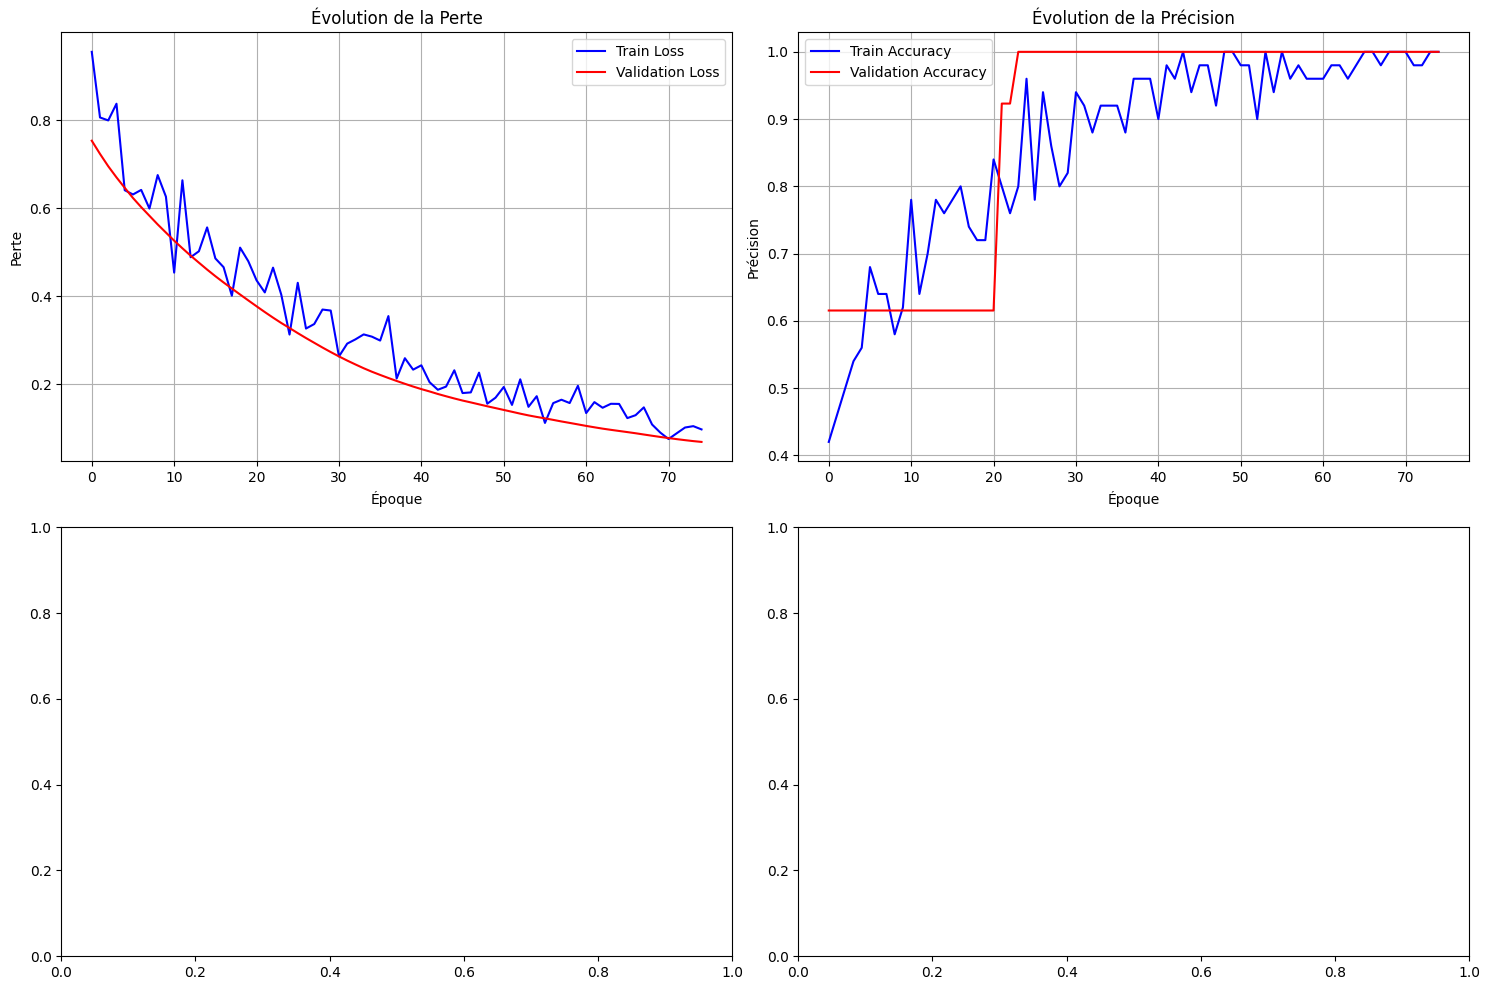

In [ ]:
def plot_training_history(history):
    """
    Affiche les courbes d'entraînement
    """
    if history is None:
        return
        
    print(f"\n VISUALISATION DES COURBES D'ENTRAÎNEMENT")
    print("=" * 50)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Courbe de perte (loss)
    axes[0, 0].plot(history.history['loss'], label='Train Loss', color='blue')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axes[0, 0].set_title('Évolution de la Perte')
    axes[0, 0].set_xlabel('Époque')
    axes[0, 0].set_ylabel('Perte')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Courbe de précision (accuracy)
    axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    axes[0, 1].set_title('Évolution de la Précision')
    axes[0, 1].set_xlabel('Époque')
    axes[0, 1].set_ylabel('Précision')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Courbe de précision (precision)
    if 'precision' in history.history:
        axes[1, 0].plot(history.history['precision'], label='Train Precision', color='blue')
        axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', color='red')
        axes[1, 0].set_title('Évolution de la Précision (Precision)')
        axes[1, 0].set_xlabel('Époque')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
    
    # Courbe de rappel (recall)
    if 'recall' in history.history:
        axes[1, 1].plot(history.history['recall'], label='Train Recall', color='blue')
        axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', color='red')
        axes[1, 1].set_title('Évolution du Rappel (Recall)')
        axes[1, 1].set_xlabel('Époque')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Affichage des courbes
if history is not None:
    plot_training_history(history)

## Evaluation du modèle sur le jeu de test 


 ÉVALUATION SUR LE JEU DE TEST
 Génération des prédictions...
1/1 [==============================] - 4s 4s/step

 MÉTRIQUES DE PERFORMANCE:
   Accuracy:  1.0000 (100.00%)
   Precision: 1.0000 (100.00%)
   Recall:    1.0000 (100.00%)
    F1-Score:  1.0000 (100.00%)


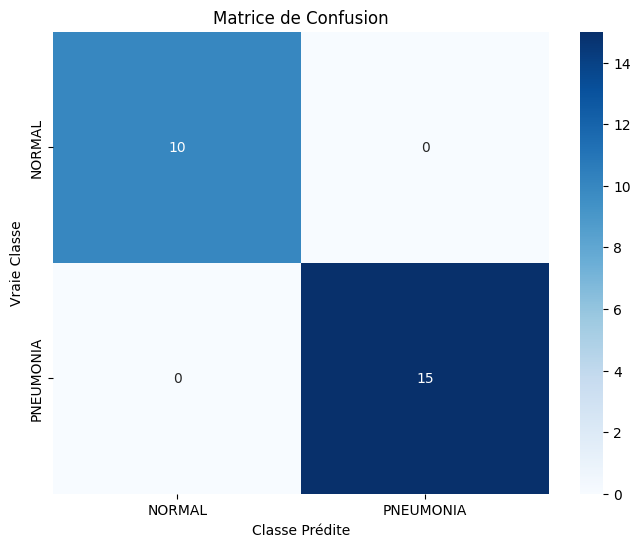


 RAPPORT DE CLASSIFICATION DÉTAILLÉ:
              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00        10
   PNEUMONIA       1.00      1.00      1.00        15

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

 Métriques de test loggées dans MLflow


In [ ]:
def evaluate_model(model, test_generator):
    """
    Évalue le modèle sur le jeu de test et affiche les métriques
    """
    if model is None or test_generator is None:
        return
        
    print(f"\n ÉVALUATION SUR LE JEU DE TEST")
    print("=" * 50)
    
    # Prédictions sur le jeu de test
    print(" Génération des prédictions...")
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=1)
    
    # Récupération des vraies labels
    true_labels = test_generator.classes
    
    # Conversion des prédictions en classes binaires
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    
    # Calcul des métriques
    accuracy = accuracy_score(true_labels, predicted_classes)
    precision = precision_score(true_labels, predicted_classes)
    recall = recall_score(true_labels, predicted_classes)
    f1 = f1_score(true_labels, predicted_classes)
    
    print(f"\n MÉTRIQUES DE PERFORMANCE:")
    print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"   Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"    F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
    
    # Matrice de confusion
    cm = confusion_matrix(true_labels, predicted_classes)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['NORMAL', 'PNEUMONIA'], 
                yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.title('Matrice de Confusion')
    plt.ylabel('Vraie Classe')
    plt.xlabel('Classe Prédite')
    plt.show()
    
    # Rapport de classification détaillé
    print(f"\n RAPPORT DE CLASSIFICATION DÉTAILLÉ:")
    print(classification_report(true_labels, predicted_classes, 
                              target_names=['NORMAL', 'PNEUMONIA']))
    
    # Log des métriques dans MLflow si disponible
    if mlflow_ready:
        try:
            with mlflow.start_run():
                mlflow.log_metrics({
                    "test_accuracy": accuracy,
                    "test_precision": precision,
                    "test_recall": recall,
                    "test_f1_score": f1
                })
            print(" Métriques de test loggées dans MLflow")
        except:
            print("  Impossible de logger dans MLflow")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# Évaluation du modèle
if model is not None and test_gen is not None:
    test_results = evaluate_model(model, test_gen)
else:
    test_results = None
    print("  Évaluation impossible - vérifiez le modèle et les données de test")

## Sauvegarde du modèle

In [ ]:
def save_model(model, filename="densenet121_pneumonia_model.h5"):
    """
    Sauvegarde le modèle entraîné
    """
    if model is None:
        return
        
    print(f"\n SAUVEGARDE DU MODÈLE")
    print("=" * 50)
    
    try:
        model.save(filename)
        print(f" Modèle sauvegardé: {filename}")
        print(f" Taille du fichier: {os.path.getsize(filename) / (1024*1024):.1f} MB")
    except Exception as e:
        print(f" Erreur lors de la sauvegarde: {e}")

# Sauvegarde du modèle
if model is not None:
    save_model(model)


 SAUVEGARDE DU MODÈLE


c:\Users\Utilisateur\Desktop\CNN_Tranfert_Learning\pneumonia_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 Modèle sauvegardé: densenet121_pneumonia_model.h5
 Taille du fichier: 31.4 MB
